## **Ganga River Basin Modeling Using Landlab**


## Group Members
Ketan (24210054)

Rahul (21110174)

Hansin (22110090)

Hitesh (21110079)



# Introduction

  Welcome to our group project on the Ganga River Basin. In this project, we utilize the powerful capabilities of Landlab, a Python-based modeling toolkit, to simulate and analyze the geomorphological the Ganga river basin. Our focus is on understanding how waterbodies form and how the landscape evolves over time due to various natural processes.

  The Ganga river basin is one of the most significant and dynamic river systems in the world, supporting millions of people and a rich biodiversity. Studying its evolution helps us gain valuable insights into water resource.

# Ganga River: Location & Geological Features



*   Origin: Gangotri Glacier, Himalayas, Uttarakhand, India.

*   Flows southeast across northern India, enters Bangladesh as the Padma, and empties into the Bay of Bengal.
*   Length: ~2,525 km; Basin area: ~1,080,000 km²

*   Key Features: Himalayan mountains, flat Gangetic plains, the Sundarbans delta, and rich alluvial soils
*   Our Stuidy area: Varanasi, Uttar Pradesh.  Lat 25N, Lon 83E

*   Tectonic Origin: Formed in the Indo-Gangetic foreland basin due to Himalayan uplift.

*   Alluvial Deposits: Carries thick layers of fertile sediments across the plains.

*   Meandering Channels: Shows winding patterns in its middle and lower courses.

*   Floodplain Features: Creates oxbow lakes, levees, and seasonal backswamps.


# What is Landlab?

Landlab is an open-source Python library designed to simulate Earth surface processes. It's widely used in geoscience research and education to model how landscapes evolve over time due to processes like erosion, sediment transport, river formation, vegetation growth, and urban heat.. It uses flexible grids and modular components, making it easy to build and visualize landscape models in Python or Colab.

We use Landlab here to model waterbody formation and landscape evolution in the Ganga basin.

# Objectives

*   Simulate waterbody formation in the Ganga basin.
*   Model and observe landscape evolution.
*   Analyze simulation results.
*   Demonstrate Landlab’s use in real-world earth science.


In [ ]:
pip install landlab bmi-topography xarray rioxarray rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.8 MB/s eta 0:00:00


ChannelProfiler error: The number of watersheds requested by the ChannelProfiler is greater than the number in the domain with channel_definition_field area. [105300.]


/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


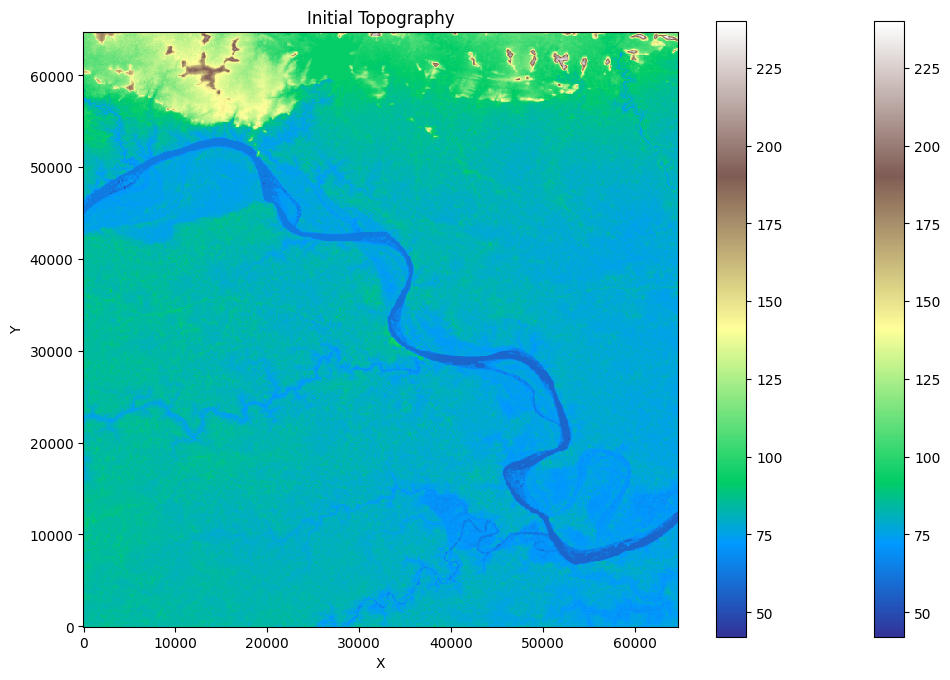

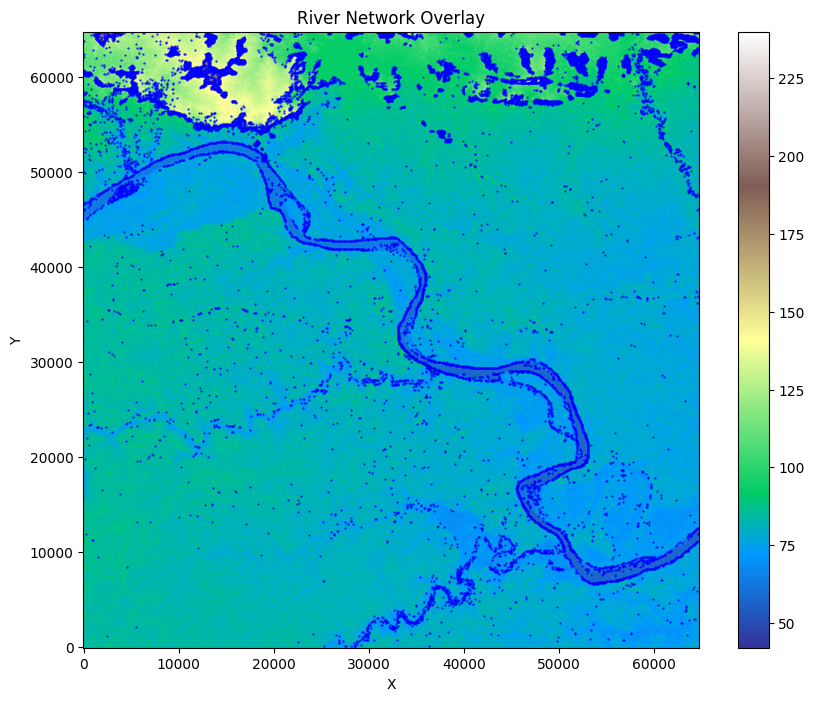

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
from landlab.components import (
    FlowAccumulator,
    StreamPowerEroder,
    ChannelProfiler,
    SoilInfiltrationGreenAmpt,
    DepressionFinderAndRouter,
)
from matplotlib.animation import FuncAnimation
from bmi_topography import Topography
import xarray as xr
import rioxarray

# --- DEM Downloader ---
def getTerrain(south, north, west, east, cache_dir="."):
    topo = Topography(
        dem_type="SRTMGL3",
        south=south, north=north,
        west=west, east=east,
        output_format="GTiff",
        cache_dir=cache_dir,
        api_key="80b9cb3beb933648543e9c50c9326579"
    )
    topo.fetch()
    da = topo.load()
    da.rio.write_crs("EPSG:4326", inplace=True)
    return da

# --- Define Spatial Limits (Ganga River area, Varanasi region) ---
lat_center, lon_center = 25.3, 83
buffer = 0.3  # You can reduce this to 0.2 for smaller domain
south = lat_center - buffer
north = lat_center + buffer
west = lon_center - buffer
east = lon_center + buffer

# --- Simulation Parameters ---
dt = 200
nr_time_steps = 1500
xy_spacing = 90  # meters
K_sp = 1e-6
m_sp = 0.4
n_sp = 1.1
uplift = 0.0003

# --- Get DEM ---
da = getTerrain(south, north, west, east)
dem_raw = da.data[0]
dem_clean = np.where(np.isnan(dem_raw), np.nanmin(dem_raw), dem_raw)
dem_master = np.array(dem_clean, dtype=np.float64)
nrows, ncols = dem_master.shape

# --- Initialize Grid ---
grid = RasterModelGrid((nrows, ncols), xy_spacing)
z = grid.add_zeros("topographic__elevation", at="node")
z[:] = dem_master.flatten()

# --- Depression Filling BEFORE Flow Routing ---
depression_filler = DepressionFinderAndRouter(grid)
depression_filler.map_depressions()

# --- Initialize Components ---
flow_acc = FlowAccumulator(grid)
eroder = StreamPowerEroder(grid, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp)
grid.add_zeros('soil_water_infiltration__depth', at='node')
grid.add_zeros('surface_water__depth', at='node')

infiltration = SoilInfiltrationGreenAmpt(
    grid,
    hydraulic_conductivity=0.001,
    soil_bulk_density=1600.0,
    initial_soil_moisture_content=0.1
)

flow_acc.run_one_step()

# --- Convert Drainage Area to m² ---
drainage_area = grid.at_node['drainage_area'] * (xy_spacing ** 2)

# --- Updated Channel Profiler Threshold ---
min_channel_area_m2 = 2e7
if np.sum(drainage_area > min_channel_area_m2) > 10:
    try:
        profiler = ChannelProfiler(
            grid,
            minimum_channel_threshold=min_channel_area_m2,
            number_of_watersheds=1
        )
    except ValueError as e:
        print(f"ChannelProfiler error: {e}")
else:
    print("Warning: Not enough drainage area for profiling. Skipping ChannelProfiler.")

# --- Simulation Setup ---
fig, ax = plt.subplots(figsize=(12, 8))
elev_plot = grid.imshow('node', z, cmap='terrain')
plt.colorbar(elev_plot, ax=ax)
ax.set_title("Initial Topography")

def update(frame):
    for _ in range(5):
        infiltration.run_one_step()
        flow_acc.run_one_step()
        eroder.run_one_step(dt)
        z[:] += uplift * dt

    ax.clear()
    grid.imshow('node', z, cmap='terrain', ax=ax)
    ax.set_title(f"Landscape Evolution - Year {frame * dt * 5}")
    return ax

anim = FuncAnimation(fig, update, frames=30, interval=400)
plt.show()

# --- River Overlay (After Simulation) ---
flow_acc.run_one_step()
drainage_area = grid.at_node['drainage_area'] * (xy_spacing ** 2)

# Filter for slope AND area (optional, for cleaner rivers)
steep_nodes = (drainage_area > min_channel_area_m2) & (grid.at_node['topographic__steepest_slope'] > 0.06)

# Plot river network
plt.figure(figsize=(10, 8))
grid.imshow('node', z, cmap='terrain')
x, y = grid.xy_of_node.T
plt.plot(x[steep_nodes], y[steep_nodes], 'b.', markersize=1)
plt.title("River Network Overlay")
plt.show()

## 🌧️ Simulating Landscape Evolution Under Storm and Rainfall Conditions Using Landlab

This Python script demonstrates the simulation of **landscape evolution driven by rainfall events and storm-induced erosion**, using real-world elevation data. By integrating various **Landlab components** such as `FlowAccumulator`, `StreamPowerEroder`, `KinwaveImplicitOverlandFlow`, and `PrecipitationDistribution`, the model visualizes how rainfall patterns influence **river formation, channel incision**, and **terrain modification** over time. The script fetches a **SRTM-based Digital Elevation Model (DEM)** centered at Ganga River, simulates storm-induced erosion over a 10-hour period, and dynamically visualizes the evolving topography along with river networks using **matplotlib animations**.

---

## What This Code Does

1. **Downloads DEM Data** for a specified region using the `bmi-topography` package.
2. **Cleans and loads the DEM** into a `RasterModelGrid`—Landlab’s foundational grid structure.
3. **Initializes hydrological and erosion models** using Landlab components.
4. **Simulates multiple landscape processes**: rainfall, overland flow, infiltration, erosion, and uplift.
5. **Overlays and visualizes the river networks** at the end based on drainage area and slope.

---

## Key Components and Their Roles

### 🔹 `FlowAccumulator`
Calculates **drainage area**, **flow direction**, and **flow receiver nodes**. It's essential for simulating how water flows over the landscape.

### 🔹 `StreamPowerEroder`
Simulates **river incision** and **fluvial erosion** using the stream power law
$$E = K A^m S^n$$

Where:
- E is the erosion rate,
- K is the erodibility coefficient (K_sp),
- A is the drainage area,
- S is the local slope,
- 𝑚 and 𝑛 are empirical exponents controlling how erosion responds to area and slope.

### 🔹 `DepressionFinderAndRouter`
Identifies closed depressions (pits) in the landscape that would trap water and reroutes flow around them.

### 🔹 `PrecipitationDistribution`
Generates synthetic **rainfall events**, including storm and interstorm durations and rainfall depths.

### 🔹 `SoilInfiltrationGreenAmpt`
Simulates **infiltration of surface water** into the soil using the **Green-Ampt infiltration model**, a widely used physically-based approach.

### 🔹 `KinwaveImplicitOverlandFlow`
Simulates **overland flow of surface water** using a kinematic wave approach, capturing runoff behavior during rainfall.

### 🔹 `ChannelProfiler`
Extracts and plots **channel profiles** (longitudinal river profiles) from the terrain, useful for watershed analysis and geomorphological insights.

---

## Dynamic Simulation

The simulation simulates and performs the following task for each frame:
- Rainfall is generated.
- Water depth is updated.
- Infiltration and overland flow are computed.
- Erosion is applied.
- The surface is uplifted to simulate tectonic activity.

This provides a time-lapse visualization of how the terrain evolves under combined natural forces.

---

## River Network Visualization

After the simulation:
- `FlowAccumulator` is re-run to calculate final drainage areas.
- Nodes with large contributing areas and steep slopes are selected to represent **river channels**.
- These are plotted as blue dots over the final terrain map to highlight **river networks** formed through the simulation.

---

## Summary

This simulation beautifully brings together real-world topographic data and physics-based models of hydrology and erosion to show how landscapes evolve. It's a powerful example of using **Landlab** for environmental modeling, educational visualization, or even regional planning research.

ChannelProfiler error: The number of watersheds requested by the ChannelProfiler is greater than the number in the domain with channel_definition_field area. [105300.]


/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


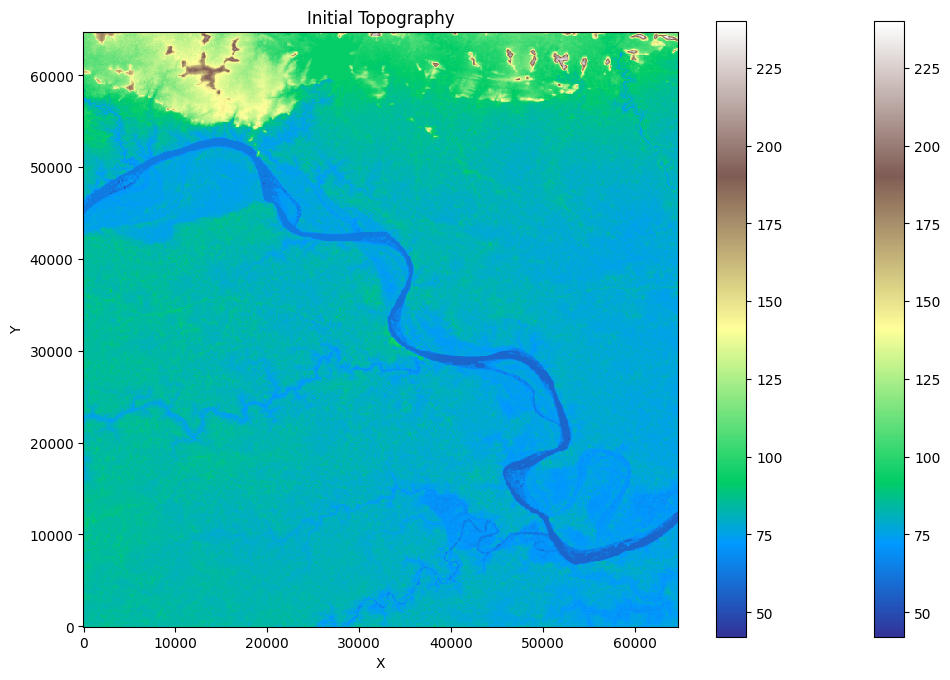

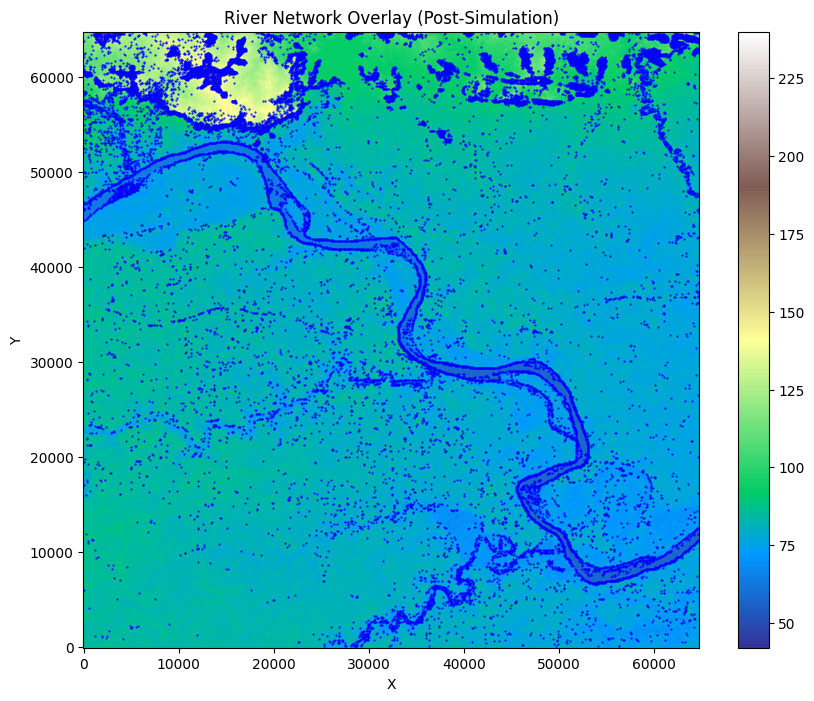

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
from landlab.components import (
    FlowAccumulator,
    StreamPowerEroder,
    ChannelProfiler,
    SoilInfiltrationGreenAmpt,
    DepressionFinderAndRouter,
    PrecipitationDistribution,
    KinwaveImplicitOverlandFlow
)
from matplotlib.animation import FuncAnimation
from bmi_topography import Topography
import xarray as xr
import rioxarray

# --- DEM Downloader ---
def getTerrain(south, north, west, east, cache_dir="."):
    topo = Topography(
        dem_type="SRTMGL3",
        south=south, north=north,
        west=west, east=east,
        output_format="GTiff",
        cache_dir=cache_dir,
        api_key="80b9cb3beb933648543e9c50c9326579"
    )
    topo.fetch()
    da = topo.load()
    da.rio.write_crs("EPSG:4326", inplace=True)
    return da

# --- Spatial Domain Setup ---
lat_center, lon_center = 25.3, 83
buffer = 0.3
south, north = lat_center - buffer, lat_center + buffer
west, east = lon_center - buffer, lon_center + buffer

# --- Simulation Parameters ---
dt = 60.0  # seconds
total_run_time = 3600 * 10  # 10 hours
xy_spacing = 90
K_sp = 1e-6
m_sp = 0.4
n_sp = 1.1
uplift = 0.0003

# --- Get DEM ---
da = getTerrain(south, north, west, east)
dem_raw = da.data[0]
dem_clean = np.where(np.isnan(dem_raw), np.nanmin(dem_raw), dem_raw)
dem_master = np.array(dem_clean, dtype=np.float64)
nrows, ncols = dem_master.shape

# --- Initialize Grid ---
grid = RasterModelGrid((nrows, ncols), xy_spacing)
z = grid.add_zeros("topographic__elevation", at="node")
z[:] = dem_master.flatten()

# --- Depression Filling ---
depression_filler = DepressionFinderAndRouter(grid)
depression_filler.map_depressions()

# --- Initialize Fields ---
depth = grid.add_zeros("surface_water__depth", at="node")
infilt = grid.add_zeros("soil_water_infiltration__depth", at="node")
infilt[:] = 1e-4  # small positive value to start

# --- Components ---
flow_acc = FlowAccumulator(grid)
eroder = StreamPowerEroder(grid, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp)

# Rainfall generator
storm = PrecipitationDistribution(
    mean_storm_duration=10000,
    mean_interstorm_duration=600,
    total_t=total_run_time,
    delta_t=dt,
    mean_storm_depth=0.5,  # *1000 mm
)
storm._rng = np.random.default_rng(42)

# Infiltration and Overland Flow
ga = SoilInfiltrationGreenAmpt(
    grid,
    hydraulic_conductivity=0.001,
    soil_bulk_density=1600.0,
    initial_soil_moisture_content=0.1
)

kw = KinwaveImplicitOverlandFlow(
    grid,
    roughness=0.1,
    depth_exp=5.0 / 3.0
)

# --- Channel Profiler ---
flow_acc.run_one_step()
drainage_area = grid.at_node['drainage_area'] * (xy_spacing ** 2)
min_channel_area_m2 = 2e7
if np.sum(drainage_area > min_channel_area_m2) > 10:
    try:
        profiler = ChannelProfiler(
            grid,
            minimum_channel_threshold=min_channel_area_m2,
            number_of_watersheds=1
        )
    except ValueError as e:
        print(f"ChannelProfiler error: {e}")
else:
    print("Warning: Not enough drainage area for profiling. Skipping ChannelProfiler.")

# --- Simulation Setup ---
fig, ax = plt.subplots(figsize=(12, 8))
elev_plot = grid.imshow('node', z, cmap='terrain')
plt.colorbar(elev_plot, ax=ax)
ax.set_title("Initial Topography")

def update(frame):
    for _ in range(10):  # 10 steps per frame
        storm.update()
        rainfall_rate = storm.rainfall_rate  # m/s

        # Apply rainfall depth
        grid.at_node["surface_water__depth"][:] = rainfall_rate * dt
        kw.run_one_step(dt)
        ga.run_one_step(dt)

        # Flow & erosion
        flow_acc.run_one_step()
        eroder.run_one_step(dt)

        # Uplift
        z[:] += uplift * dt

    ax.clear()
    grid.imshow('node', z, cmap='terrain', ax=ax)
    ax.set_title(f"Landscape Evolution - Hour {int(frame * dt * 10 / 3600)}")
    return ax

anim = FuncAnimation(fig, update, frames=30, interval=300)
plt.show()

# --- Post-Simulation River Overlay ---
flow_acc.run_one_step()
drainage_area = grid.at_node['drainage_area'] * (xy_spacing ** 2)
steep_nodes = (drainage_area > min_channel_area_m2) & (grid.at_node['topographic__steepest_slope'] > 0.05)

plt.figure(figsize=(10, 8))
grid.imshow('node', z, cmap='terrain')
x, y = grid.xy_of_node.T
plt.plot(x[steep_nodes], y[steep_nodes], 'b.', markersize=1)
plt.title("River Network Overlay (Post-Simulation)")
plt.show()

“As part of this project, we aimed to visualize how natural landscapes evolve over time — specifically how erosion changes terrain. We used a DEM (Digital Elevation Model) and Python to simulate this change over a 100-year period.”

What is DEM?

A DEM is a grid-based 2D representation of terrain elevations.

Each cell stores height (in meters) above sea level.

We used SRTMGL1 DEM data (global SRTM 30m resolution).

Our Approach.

The objective was to show how a terrain erodes naturally over time.

We used:

rasterio to read DEM

numpy for math operations

matplotlib to generate images

Pillow to create an animation

How we simulated?

Terrain change was simulated using a basic diffusion model.

In each step:

Each cell’s elevation was averaged with its 4 neighbors.

Elevation diffused like how heat spreads or ink in water.

This "smooths" the surface over time, simulating erosion.

“We repeated this process 1000 times — assuming 10 steps per year — to simulate a full century.”

Every 10 steps, we saved a snapshot using matplotlib.

These snapshots were combined into a GIF.

Color bar represents elevation changes over time.

Learnings:

✅ Learned to extract and visualize DEMs.

✅ Understood basic terrain modeling.

✅ Used mathematical diffusion to simulate erosion.

❌ Did not consider:

Water flow patterns

Sediment transport

Uplift or tectonic movement


In [ ]:
!pip install rasterio --quit
!pip install landlab --quit
import os
import tarfile
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# === STEP 1: Extract DEM ===
tar_path = "/content/rasters_SRTMGL1.tar.gz"  # Replace with your file path
extracted_dir = "dem_evolution_sim"

if not os.path.exists(extracted_dir):
    os.makedirs(extracted_dir)
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=extracted_dir)
    print("✅ Extracted to:", extracted_dir)
else:
    print("✅ Already extracted.")

# === STEP 2: Find the DEM .tif file ===
dem_file = None
for root, _, files in os.walk(extracted_dir):
    for file in files:
        if file.endswith(".tif"):
            dem_file = os.path.join(root, file)
            break

if not dem_file:
    raise FileNotFoundError("❌ DEM .tif not found.")
print("📄 DEM file found:", dem_file)

# === STEP 3: Load the DEM ===
with rasterio.open(dem_file) as src:
    dem = src.read(1).astype(float)
    transform = src.transform
    dem = np.where(dem == src.nodata, np.nan, dem)

# === STEP 4: Simulate erosion over 100 years (1000 time steps) ===
def simulate_erosion(dem_data, steps=1000, intensity=0.2):
    erosion_data = dem_data.copy()
    snapshots = []

    for step in range(steps):
        # Create an erosion effect by averaging neighboring cells
        erosion_effect = np.roll(erosion_data, shift=1, axis=0) + np.roll(erosion_data, shift=-1, axis=0) + \
                         np.roll(erosion_data, shift=1, axis=1) + np.roll(erosion_data, shift=-1, axis=1)
        erosion_effect /= 4  # Averaging over 4 neighbors

        # Subtract this effect from the original data (simulating erosion)
        erosion_data -= intensity * (erosion_data - erosion_effect)
        erosion_data = np.where(np.isnan(erosion_data), np.nanmin(erosion_data), erosion_data)  # Handle NaNs

        # Save snapshots every 10 steps (to represent a yearly snapshot)
        if step % 10 == 0:
            plt.figure(figsize=(8, 6))
            plt.imshow(erosion_data, cmap='terrain', extent=[
                transform[2], transform[2] + transform[0] * src.width,
                transform[5] + transform[4] * src.height, transform[5]
            ])
            plt.colorbar(label="Elevation (m)")
            plt.title(f"Year {step // 10 + 1} - Erosion Evolution")
            plt.axis("off")
            plt.tight_layout()

            # Save the snapshot as a PNG image
            snapshot_filename = f"year_{step // 10 + 1}.png"
            plt.savefig(snapshot_filename)
            plt.close()

            snapshots.append(snapshot_filename)
            print(f"🖼️ Snapshot saved: {snapshot_filename}")

    return snapshots

# === STEP 5: Run the simulation for 100 years ===
snapshots = simulate_erosion(dem, steps=1000, intensity=0.1)

# === STEP 6: Create a GIF from the snapshots ===
frames = [Image.open(snapshot) for snapshot in snapshots]

# Save the frames as a GIF
gif_filename = "landscape_evolution_100_years.gif"
frames[0].save(gif_filename, save_all=True, append_images=frames[1:], loop=0, duration=100)

print(f"✅ GIF created: {gif_filename}")

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              


“Previously, we simulated only erosion using a basic diffusion model, which helped us understand how terrain smooths out over time. But that model was oversimplified. So, we decided to take it a step further — to include more realistic processes like uplift and stream-related erosion dynamics.”

“We began with a DEM — a Digital Elevation Model — stored in a .tif file. We extracted this from a tar archive using Python. Then, we loaded the elevation data using rasterio, and pre-processed it by handling missing values.”

The erosion in our model is governed by the stream power law:

$$E = K A^m S^n$$

Where:
- E is the erosion rate,
- K is the erodibility coefficient (K_sp),
- A is the drainage area,
- S is the local slope,
- 𝑚 and 𝑛 are empirical exponents controlling how erosion responds to area and slope.

For our simplified simulation:

We used Gaussian filtering as a proxy to estimate drainage area.

Slope was computed using numerical gradients across the DEM.

At each time step, we applied stream power erosion, followed by a small uplift rate to simulate tectonic activity.

We ran this simulation over 1,000 steps, representing approximately 100 years, and captured a snapshot every 10 steps.

Finally, we compiled these images into a GIF animation, showing the progressive erosion and uplift shaping the landscape over time.

“Initially, we learned the basics of erosion using a simple diffusion model.
Then, by adding uplift and erosion laws (KSP, MSP, NSP), we got a more intelligent simulation.
This hands-on approach helped us realize how terrain evolution is not just erosion — it's a complex balance of natural forces.”

In [ ]:
import os
import tarfile
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from PIL import Image

# === STEP 1: Extract DEM ===
tar_path = "/content/rasters_SRTMGL1.tar.gz"  # Replace with your file path
extracted_dir = "dem_evolution_sim_with_ksp_msp_nsp"

if not os.path.exists(extracted_dir):
    os.makedirs(extracted_dir)
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=extracted_dir)
    print("✅ Extracted to:", extracted_dir)
else:
    print("✅ Already extracted.")

# === STEP 2: Find the DEM .tif file ===
dem_file = None
for root, _, files in os.walk(extracted_dir):
    for file in files:
        if file.endswith(".tif"):
            dem_file = os.path.join(root, file)
            break

if not dem_file:
    raise FileNotFoundError("❌ DEM .tif not found.")
print("📄 DEM file found:", dem_file)

# === STEP 3: Load the DEM ===
with rasterio.open(dem_file) as src:
    dem = src.read(1).astype(float)
    transform = src.transform
    dem = np.where(dem == src.nodata, np.nan, dem)

# === STEP 4: Stream Power Model parameters ===
K_sp = 1e-5  # Erodibility coefficient
m_sp = 0.5   # Power on drainage area
n_sp = 1.0   # Power on slope
uplift_rate = 0.0001  # m/year (e.g., 0.1 mm/year)

# === STEP 5: Approximate drainage area and slope ===
def compute_drainage_area(dem):
    """Approximate local drainage area using accumulation from lower neighbors."""
    filled = np.nan_to_num(dem, nan=np.nanmin(dem))
    inverted = -filled
    acc = gaussian_filter(inverted, sigma=3)  # very rough proxy for drainage area
    acc -= np.min(acc)
    return acc / np.max(acc)  # normalize to [0, 1]

def compute_slope(dem):
    dzdx = np.gradient(dem, axis=1)
    dzdy = np.gradient(dem, axis=0)
    slope = np.sqrt(dzdx**2 + dzdy**2)
    return slope

# === STEP 6: Evolve landscape ===
def simulate_stream_power_erosion(dem, steps=1000, uplift_rate=0.0001, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp):
    erosion_data = dem.copy()
    snapshots = []

    for step in range(steps):
        slope = compute_slope(erosion_data)
        area = compute_drainage_area(erosion_data)

        # Stream power erosion equation: E = K * A^m * S^n
        erosion_rate = K_sp * (area ** m_sp) * (slope ** n_sp)

        # Apply erosion and uplift
        erosion_data -= erosion_rate
        erosion_data += uplift_rate

        # Replace NaNs with min elevation
        erosion_data = np.where(np.isnan(erosion_data), np.nanmin(erosion_data), erosion_data)

        # Save snapshots every 10 steps (~1 year)
        if step % 10 == 0:
            plt.figure(figsize=(8, 6))
            plt.imshow(erosion_data, cmap='terrain', extent=[
                transform[2], transform[2] + transform[0] * src.width,
                transform[5] + transform[4] * src.height, transform[5]
            ])
            plt.colorbar(label="Elevation (m)")
            plt.title(f"Year {step // 10 + 1}")
            plt.axis("off")
            plt.tight_layout()

            snapshot_filename = f"year_{step // 10 + 1}.png"
            plt.savefig(snapshot_filename)
            plt.close()

            snapshots.append(snapshot_filename)
            print(f"🖼️ Snapshot created for year {step // 10 + 1}")

    return snapshots

# === STEP 7: Run simulation ===
snapshots = simulate_stream_power_erosion(dem, steps=1000)

# === STEP 8: Create GIF ===
frames = [Image.open(snapshot) for snapshot in snapshots]
gif_filename = "final_landscape_evolution.gif"
frames[0].save(gif_filename, save_all=True, append_images=frames[1:], loop=0, duration=100)

print(f"✅ Final GIF created: {gif_filename}")




✅ Extracted to: dem_evolution_sim_with_ksp_msp_nsp
📄 DEM file found: dem_evolution_sim_with_ksp_msp_nsp/output_SRTMGL1.tif
🖼️ Snapshot created for year 1
🖼️ Snapshot created for year 2
🖼️ Snapshot created for year 3
🖼️ Snapshot created for year 4
🖼️ Snapshot created for year 5
🖼️ Snapshot created for year 6
🖼️ Snapshot created for year 7
🖼️ Snapshot created for year 8
🖼️ Snapshot created for year 9
🖼️ Snapshot created for year 10
🖼️ Snapshot created for year 11
🖼️ Snapshot created for year 12
🖼️ Snapshot created for year 13
🖼️ Snapshot created for year 14
🖼️ Snapshot created for year 15
🖼️ Snapshot created for year 16
🖼️ Snapshot created for year 17
🖼️ Snapshot created for year 18
🖼️ Snapshot created for year 19
🖼️ Snapshot created for year 20
🖼️ Snapshot created for year 21
🖼️ Snapshot created for year 22
🖼️ Snapshot created for year 23
🖼️ Snapshot created for year 24
🖼️ Snapshot created for year 25
🖼️ Snapshot created for year 26
🖼️ Snapshot created for year 27
🖼️ Snapshot created fo

/usr/local/lib/python3.11/dist-packages/bmi_topography/api_key.py:48: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.csdms.io/en/latest/#api-key for more information.
  warnings.warn(


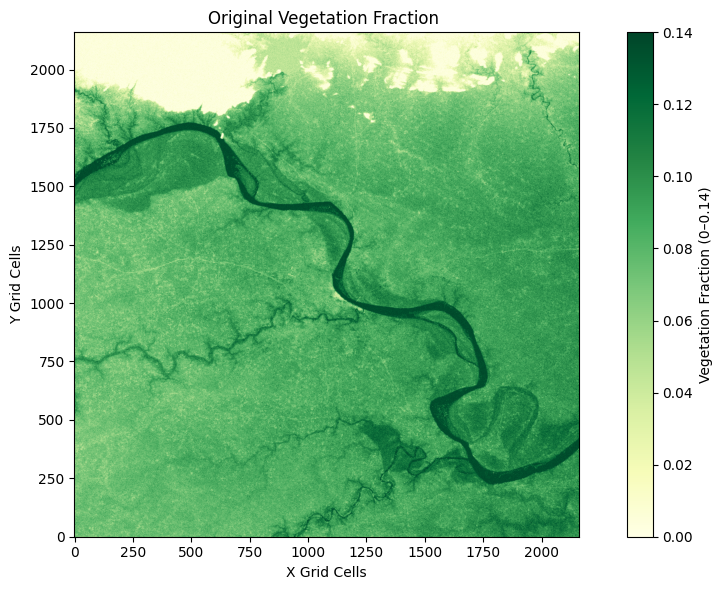

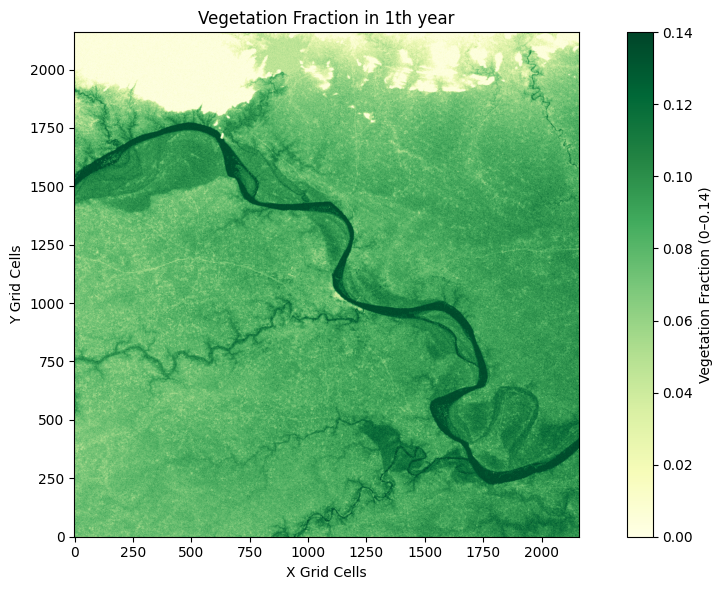

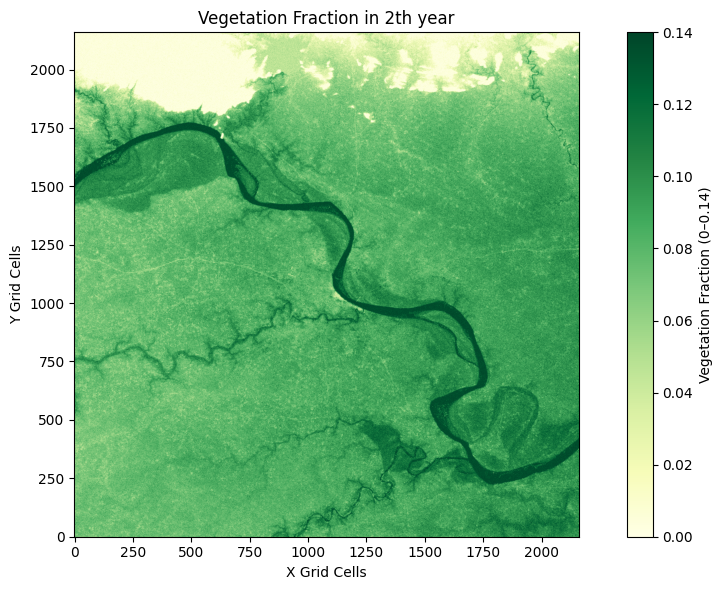

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
from landlab.components import (
    FlowAccumulator,
    StreamPowerEroder,
    ChannelProfiler,
    SoilInfiltrationGreenAmpt,
    DepressionFinderAndRouter,
    PrecipitationDistribution,
    KinwaveImplicitOverlandFlow,
    PotentialEvapotranspiration,
    SoilMoisture,
    Vegetation,
)
from matplotlib.animation import FuncAnimation
from bmi_topography import Topography
import rioxarray

# Step 1: Define bounding box around Chamundi Hill
params = {
    'dem_type': 'SRTMGL1',  # 30-meter resolution global DEM
    'south': 25,
    'north': 25.6,
    'west': 82.7,
    'east': 83.3,
    'output_format': 'GTiff',
    'cache_dir': './dem_cache'
}

# Step 2: Download the DEM
topo = Topography(**params)
dem_path = topo.fetch()  # Fetches and returns the path to the downloaded DEM file

# Step 3: Load the DEM
dem = rioxarray.open_rasterio(dem_path, masked=True).squeeze()
elev = dem.values.astype(np.float64)  # ✅ Convert to float64

# Step 4: Set up the grid
dx = dem.rio.resolution()[0]
nrows, ncols = elev.shape
mg = RasterModelGrid((nrows, ncols), xy_spacing=dx)
mg.add_field('topographic__elevation', elev.flatten(), at='node')

dt = 60.0
total_run_time = 3600 * 24 * 365 * 5  # 5 years
xy_spacing = 90
K_sp = 1e-6
m_sp = 0.4
n_sp = 1.1
uplift = 0.0003

# Compute mean elevation
mean_elev = np.mean(elev)

# Normalize elevation (0 = low, 1 = peak), then reverse for vegetation
norm_elev = (elev - np.min(elev)) / (np.max(elev) - np.min(elev))  # Normalize elevation (0 = low, 1 = peak)
base_veg = 0.1 * (1-norm_elev)

# Add vegetation fraction based on elevation
veg_frac = mg.add_zeros("vegetation__fraction", at="node")
veg_frac_2d = np.clip(base_veg + (mean_elev - elev) / (mean_elev - np.min(elev)) * 0.14, 0.0, 0.14)

# Reshape `veg_frac_2d` to match the grid
veg_frac[:] = veg_frac_2d.flatten()  # Flatten the 2D array to match the 1D node array

# Add small noise
np.random.seed(42)
noise = 0.01 * np.random.randn(mg.number_of_nodes)  # Small noise
veg_frac[:] = np.clip(veg_frac + noise, 0.0, 0.14)

# Add required fields
mg.add_ones("radiation__ratio_to_flat_surface", at="cell")
mg.add_zeros("soil_moisture__initial_saturation_fraction", at="cell")
mg.at_cell["soil_moisture__initial_saturation_fraction"] += 0.5

mg.add_zeros("vegetation__cover_fraction", at="cell")
mg.at_cell["vegetation__cover_fraction"] += 0.1

mg.add_zeros("soil__depth", at="cell")
mg.at_cell["soil__depth"] += 1.0

mg.add_zeros("rainfall__daily_depth", at="cell")
mg.at_cell["rainfall__daily_depth"] += 5.0

mg.add_zeros("vegetation__live_leaf_area_index", at="cell")
mg.at_cell["vegetation__live_leaf_area_index"] += 0.1

mg.add_zeros("vegetation__plant_functional_type", at="cell", dtype=int)
mg.at_cell["vegetation__plant_functional_type"][:] = 1

mg.add_zeros("surface__potential_evapotranspiration_30day_mean", at="cell")
mg.at_cell["surface__potential_evapotranspiration_30day_mean"][:] = 5.0

# Plotting the initial vegetation fraction
plt.figure(figsize=(10, 6))
plt.title("Original Vegetation Fraction ")
veg_plot = mg.at_node["vegetation__fraction"].reshape((nrows, ncols))
plt.imshow(veg_plot, cmap="YlGn", origin="lower")
plt.colorbar(label="Vegetation Fraction (0–0.14)")
plt.xlabel("X Grid Cells")
plt.ylabel("Y Grid Cells")
plt.tight_layout()
plt.show()

# Components
flow_acc = FlowAccumulator(mg)
eroder = StreamPowerEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp)
precip = PrecipitationDistribution(mg, mean_storm_duration=10000,
                                   mean_interstorm_duration=600,
                                   mean_storm_depth=0.5)
precip._rng = np.random.default_rng(42)
pet = PotentialEvapotranspiration(mg, method="Constant")
soil_moisture = SoilMoisture(mg)
vegetation = Vegetation(mg)

# Simulate for next 5 ye (365 days)
for year in range(5):
    precip.update()
    pet.update()
    soil_moisture.update()
    vegetation.update()

    # Plotting the final vegetation fraction after one year
    plt.figure(figsize=(10, 6))
    plt.title(f"Vegetation Fraction in {year+1}th year")
    veg_plot = mg.at_node["vegetation__fraction"].reshape((nrows, ncols))
    plt.imshow(veg_plot, cmap="YlGn", origin="lower")
    plt.colorbar(label="Vegetation Fraction (0–0.14)")
    plt.xlabel("X Grid Cells")
    plt.ylabel("Y Grid Cells")
    plt.tight_layout()
    plt.show()